## Supervised Machine Learning to predict Used-Car prices
#### Using data from craigslist.org

In this short-project, I used a dataset downloaded from kaggle https://www.kaggle.com/austinreese/craigslist-carstrucks-data to study implmentation of supervised learning methods in scikit. The dataset has information about used cars listed for sale on craigslist. It has various types of information about the car, such as make, model, year of manufacture, odormeter reading, color, condition, etc. It also lists the asking price of the car. 

I did preprocessing of the data using Pandas and then performed some preliminary analysis using Numpy and Matplotlib. Finally, I applied a variety of supervised learning methods such as Ridge regression, ElasticNet, Support Vector Regressor, Gradient Boost, XGBoost, etc. from the Scikit learn library to predict the price and compared the performance of the models for their accuracy and runtime.

In [1]:
# Import necessary modules

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set()
from wordcloud import WordCloud

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

from scipy.stats import jarque_bera
from scipy.stats import normaltest

import warnings
warnings.filterwarnings(action='ignore')
import time

import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
#data location - https://www.kaggle.com/austinreese/craigslist-carstrucks-data/download
df_raw_data=pd.read_csv('vehicles.csv')
print(df_raw_data.shape)
df_raw_data.head(3)

(426880, 26)


,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN


In [3]:
df_raw_data.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long',
       'posting_date'],
      dtype='object')

The dataset contains 426880 rows and 26 columns. First let's drop the columns which do not contain useful information. Columns 'url', 'region', 'region_url', 'image_url', 'description', 'VIN', 'county', 'state', 'lat', 'long', 'posting_date' are unnecessary. Let's drop these columns.

In [4]:
df_useful_columns = df_raw_data.drop(['url', 'region', 'region_url', 'image_url', 'description', 'VIN', 'county', 'state', 'lat', 'long', 'posting_date'], axis=1)

In [5]:
df_useful_columns.isna().sum()

id                   0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
drive           130567
size            306361
type             92858
paint_color     130203
dtype: int64

Checking resulting dataframe for nulls we can see that the target variable 'price' does not contain any nulls which is good. 

In [6]:
price_less_10 = (df_useful_columns['price'] < 10).sum()
price_more_150K = (df_useful_columns['price'] > 150000).sum()
print('No. of vehicles with price less than $10:', price_less_10)
print('No. of vehicles with price more than $150,000:', price_more_150K)

No. of vehicles with price less than $10: 34929
No. of vehicles with price more than $150,000: 196


Let's drop the rows with price less than 10  and more than  150K$.

In [7]:
df_useful_columns = df_useful_columns[df_useful_columns['price'] > 10];
df_useful_columns = df_useful_columns[df_useful_columns['price'] < 150000];

In [8]:
df_useful_columns.shape

(391718, 15)

In [9]:
df_useful_columns.isna().sum()

id                   0
price                0
year              1173
manufacturer     15852
model             4606
condition       150548
cylinders       159505
fuel              2594
odometer          2284
title_status      7734
transmission      1816
drive           119262
size            281737
type             84942
paint_color     116154
dtype: int64

There are certain columns where the unknown values can be replaced by some text to avoid dropping the rows. Such as the if the 'color' is unknown we can substitute NaN with 'unknown' to avoid dropping these columns.

In [10]:
df_useful_columns['paint_color'].fillna('unknown', inplace = True)
df_useful_columns['condition'].fillna('unknown', inplace = True)
df_useful_columns['type'].fillna('unknown', inplace = True)

In [11]:
df_cars_nonulls = df_useful_columns.dropna()

### Feature Engineering

The dataset has two columns 'manufacturer' which is vehicle brand and 'model'. We will combine these columns into one. 
To reduce number of unique spellings of the model we will remove spaces, '-', and '.' from model name.

In [12]:
df_cars_nonulls['manufacturer'][1:10]

55         ford
59        honda
65         ford
73        dodge
86     chrysler
110    chrysler
119      toyota
138        jeep
177        ford
Name: manufacturer, dtype: object

In [13]:
df_cars_nonulls['model'] = df_cars_nonulls['model'].str.replace('-','')
df_cars_nonulls['model'] = df_cars_nonulls['model'].str.replace(' ','')
df_cars_nonulls['model'] = df_cars_nonulls['model'].str.replace('/','')
df_cars_nonulls['model'] = df_cars_nonulls['model'].str.replace('.','')
df_cars_nonulls['model'] = df_cars_nonulls['model'].str.replace(',','')
df_cars_nonulls['make_model'] = df_cars_nonulls['manufacturer']+'_'+df_cars_nonulls['model']

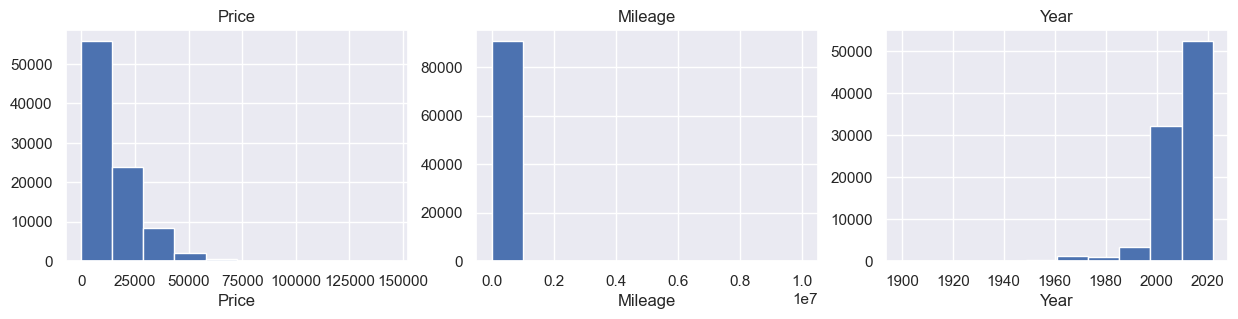

In [14]:
fig = plt.figure(figsize= (15,3))
plt.subplot(1,3,1)
df_cars_nonulls['price'].hist()
plt.title('Price')
plt.xlabel('Price')
plt.subplot(1,3,2)
plt.title('Mileage')
plt.xlabel('Mileage')
df_cars_nonulls['odometer'].hist()
plt.subplot(1,3,3)
plt.title('Year')
plt.xlabel('Year')
df_cars_nonulls['year'].hist()
plt.show()

## Description of clean dataset

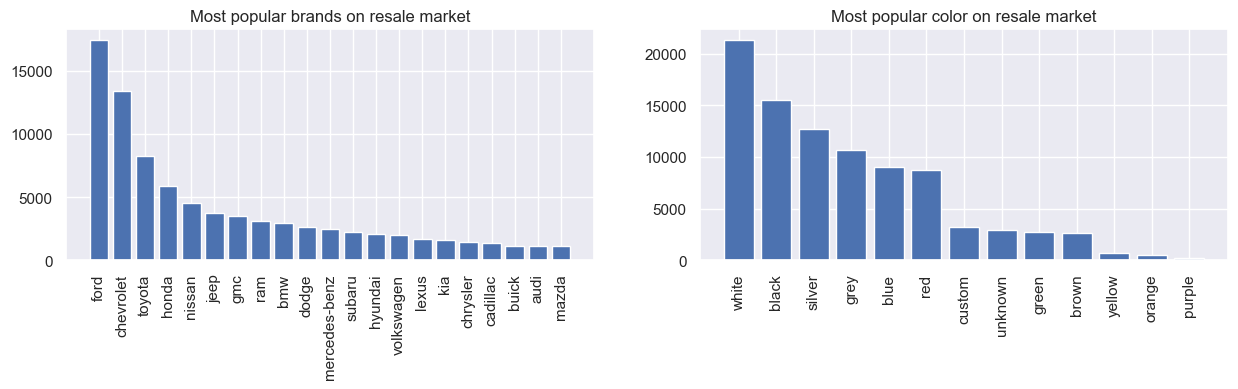

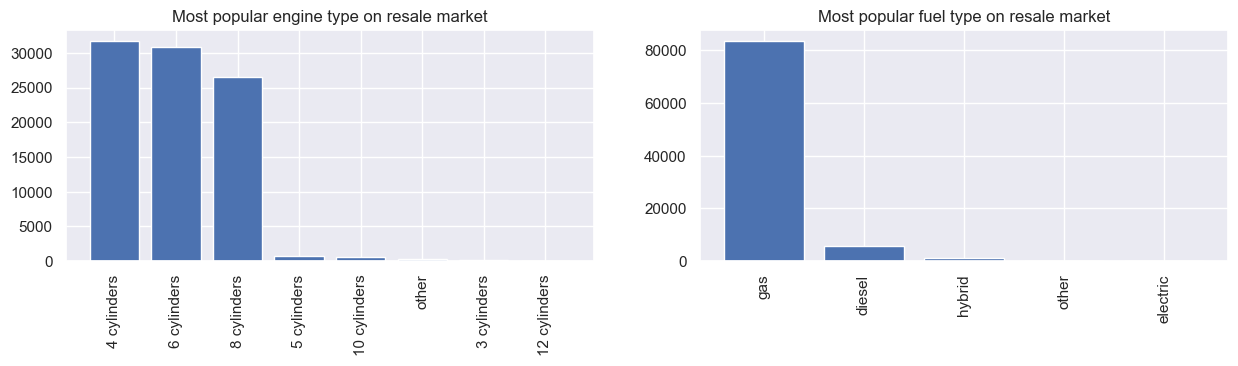

In [15]:
df_count_brands = pd.DataFrame({'count':df_cars_nonulls.groupby('manufacturer').size()}).reset_index();
df_count_brands.sort_values(by='count', ascending = False, inplace = True);
df_count_brands = df_count_brands[df_count_brands['count']>1000];

df_count_color = pd.DataFrame({'count':df_cars_nonulls.groupby('paint_color').size()}).reset_index();
df_count_color.sort_values(by='count', ascending = False, inplace = True);
df_count_color = df_count_color[df_count_color['count']>100];

df_count_engine = pd.DataFrame({'count':df_cars_nonulls.groupby('cylinders').size()}).reset_index();
df_count_engine.sort_values(by='count', ascending = False, inplace = True);

df_count_fuel = pd.DataFrame({'count':df_cars_nonulls.groupby('fuel').size()}).reset_index();
df_count_fuel.sort_values(by='count', ascending = False, inplace = True);
df_count_fuel = df_count_fuel[df_count_fuel['count']>100];

fig = plt.figure(figsize = (15,3))
plt.subplot(1,2,1)
plt.title('Most popular brands on resale market')
plt.bar(df_count_brands['manufacturer'], df_count_brands['count'])
plt.xticks(rotation = 90)

plt.subplot(1,2,2)
plt.title('Most popular color on resale market')
plt.bar(df_count_color['paint_color'], df_count_color['count'])
plt.xticks(rotation = 90)
plt.show()

fig = plt.figure(figsize = (15,3))
plt.subplot(1,2,1)
plt.title('Most popular engine type on resale market')
plt.bar(df_count_engine['cylinders'], df_count_engine['count'])
plt.xticks(rotation = 90)

plt.subplot(1,2,2)
plt.title('Most popular fuel type on resale market')
plt.bar(df_count_fuel['fuel'], df_count_fuel['count'])
plt.xticks(rotation = 90)
plt.show()


In [16]:
df_count_brands.head()

,manufacturer,count
13,ford,17396
7,chevrolet,13376
38,toyota,8269
16,honda,5886
30,nissan,4568


Let's look at some statistics such as mean price, mean age, mileage, etc. to get a sense of the data.

In [17]:
mean_price = df_cars_nonulls['price'].mean()
mean_year= df_cars_nonulls['year'].mean()
mean_miles = df_cars_nonulls['odometer'].mean()

In [18]:
print('Number of records:', df_cars_nonulls.shape[0])
print(f'Average price:     {round(mean_price,2)}$')
print(f'Average age:       {round(2023 - mean_year,2)} years')
print(f'Average mileage:   {round(mean_miles,2)} miles')

Number of records: 90913
Average price:     14641.63$
Average age:       14.1 years
Average mileage:   118847.69 miles


In [19]:
df_cars_nonulls['make_model'].nunique()

9131

As 'make_model' contains more than eleven thousand unique values (too many for hot encoding), to reduce the number of unique models we will drop the models that occur less than 10 times in the dataset.

In [20]:
# Make a dataframe from nonull cars dataframe 
# that has the count of various manufactuers and their models.
df_count = pd.DataFrame({'count': df_cars_nonulls.groupby('make_model').size()}).reset_index()
df_count.sort_values(by = 'make_model', ascending = True)

# Make a list of the manufacturers and models which are listed more than 10 times. 
pass_model_list = list(df_count[df_count['count'] > 10]['make_model'].unique())
# Convert the list to a set.
pass_model_list = set(pass_model_list)

# Now make a dataframe from the nonull car dataframe that 
# contains these manufacturers and models. We will use the set
# above to choose such cars.
df_makemodel = df_cars_nonulls[df_cars_nonulls['make_model'].isin(pass_model_list)]
df_makemodel.drop(['manufacturer', 'model'], axis = 1, inplace = True)
df_makemodel['make_model'].nunique()

1174

Now we have ~1200 unique models, so we can hot encode the dataset.

In [21]:
df_makemodel_dummy = pd.get_dummies(df_makemodel, drop_first=True)
df_makemodel_dummy['log_price'] = np.log(df_makemodel_dummy['price'])

In [54]:
# To accelerate the modeling process we will choose a subset of the dataset. 
# Let's choose 10%  of the dataset.

df_sample = df_makemodel_dummy.sample(frac=0.10)

X_data = df_sample.drop(['id', 'price', 'log_price', 'odometer'], axis=1)
Y_data = df_sample['log_price']

In [55]:
# Splitting data into train and test sets, with 20% test size
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2)

## Modeling

In this project we are trying to predict the price of used vehicles. Because price (target variable) is a continuous variable, we should use regression models. We start with DummyRegressor to see if just random guess can predict outcome and to establish base-line of the accuracy.

In [56]:
dumreg = DummyRegressor()
dumreg.fit(X_train, y_train)
print('Dummy regressor score:', dumreg.score(X_train, y_train), #
      '\nDummy test score:', dumreg.score(X_test, y_test))

Dummy regressor score: 0.0 
Dummy test score: -0.00017484181876037397


Dummy regressor gives 0 train and test scorem which indicates that target varaible can not be predicted just by guess.

We will not test several other regression models, and compare their performance. We will choose runtime and accuray as the metric for comparison. The models we study are: Ridge regression, ElasticNet, Support Vector Machine, Random Forest, Gradient boost, and XGBoost.

In [57]:
df_results = pd.DataFrame(columns = ['RegModel', 'R-score', 'Run Time'])

## Ridge Regression

start_time = time.time()
ridgeregr = Ridge()
ridgeregr.fit(X_train, y_train)
run_time = time.time() - start_time
df_ridge = pd.DataFrame({'RegModel':['Ridge'],
                                'R-score':[ridgeregr.score(X_test, y_test)],
                                'Run Time':[run_time]})
## Elastic Net

start_time = time.time()
Elasticregr = ElasticNet()
Elasticregr.fit(X_train, y_train)
run_time = time.time() - start_time
df_elastic = pd.DataFrame({'RegModel':['ElasticNet'],
                                'R-score':[Elasticregr.score(X_test, y_test)],
                                'Run Time':[run_time]})
## Support Vector Regressor

start_time = time.time()
svr_rgr = SVR(kernel = 'rbf')
svr_rgr.fit(X_train, y_train)
run_time = time.time() - start_time
df_SVR = pd.DataFrame({'RegModel':['SVR'],
                                'R-score':[svr_rgr.score(X_test, y_test)],
                                'Run Time':[run_time]})
## Random Forest

start_time = time.time()
rf_rgr = RandomForestRegressor( max_depth=15, n_estimators=150, n_jobs=3)
rf_rgr.fit(X_train, y_train)
run_time = time.time() - start_time
df_RF = pd.DataFrame({'RegModel':['Random Forest'],
                                'R-score':[rf_rgr.score(X_test, y_test)],
                                'Run Time':[run_time]})
## Gradient Boost

start_time = time.time()
grbst = GradientBoostingRegressor(learning_rate=0.1, 
                                  max_depth=15, 
                                  n_estimators=150)
grbst.fit(X_train, y_train)
run_time = time.time() - start_time
df_GRBst = pd.DataFrame({'RegModel':['GradientBoost'],
                                'R-score':[grbst.score(X_test, y_test)],
                                'Run Time':[run_time]})
## XGBoost

start_time = time.time()
xgb=XGBRegressor(learning_rate=0.1, max_depth=15, n_estimators=150, 
                nthread=3)
xgb.fit(X_train, y_train)
run_time = time.time() - start_time
df_XGBst = pd.DataFrame({'RegModel':['XGBoost'],
                                'R-score':[xgb.score(X_test, y_test)],
                                'Run Time':[run_time]})


df_results = pd.concat([df_ridge, df_elastic, df_SVR, df_RF, df_GRBst, df_XGBst], ignore_index=True)

In [58]:
df_results

,RegModel,R-score,Run Time
0,Ridge,0.441377,0.084718
1,ElasticNet,0.083761,0.130164
2,SVR,0.032097,14.718998
3,Random Forest,0.551723,2.432553
4,GradientBoost,0.548927,19.576184
5,XGBoost,0.547906,1.545934


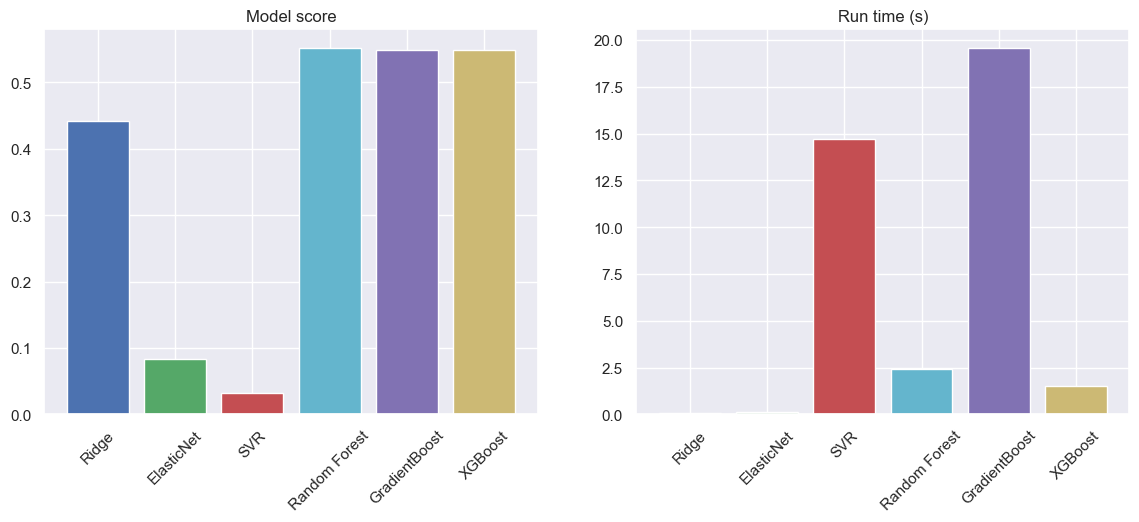

In [59]:
clr_lst = ['b','g','r','c','m','y']
fig = plt.figure(figsize= (14,5))
plt.subplot(1,2,1)
plt.title ('Model score')
plt.bar(df_results['RegModel'],df_results['R-score'],color =clr_lst)
plt.xticks(rotation=45)

plt.subplot(1,2,2)
plt.title ('Run time (s)')
plt.bar(df_results['RegModel'],df_results['Run Time'], color =clr_lst)
plt.xticks(rotation=45);

In [60]:
# 
y_pred_test_ridge  = ridgeregr.predict(X_test)
y_pred_test_elnet  = Elasticregr.predict(X_test)
y_pred_test_svr  = svr_rgr.predict(X_test)
y_pred_test_rfr  = rf_rgr.predict(X_test)
y_pred_test_grbst  = grbst.predict(X_test)
y_pred_test_xgb  = xgb.predict(X_test)

## Fine Tuning of XGBoost Model

We will fine the XGboost boost model, which has a high R^2 as well as a low run time. 

For fine tuning we will run a grid search of the parameters: Learning rate, height of trees (max_depth), number of trees in the forest (n_estimators), and regularization (reg_lambda).



In [61]:
Xgb = XGBRegressor(learning_rate = 0.1, max_depth = 10, n_estimators = 100,
                  mthread=3, reg_lambda=2, random_state=44)

In [65]:
%%time
params = {'learning_rate':[0.05,0.1,0.3],
          'max_depth':[15],
          'n_estimators':[150],
          'reg_lambda':[10]}
gridXG = GridSearchCV(xgb, param_grid=params, cv=3, return_train_score=True,n_jobs=3)
gridXG.fit(X_data, Y_data)
print('Best parameters:', gridXG.best_params_)
print('Best score:', gridXG.best_score_)

/Users/vijaypersonal/Library/Python/3.11/lib/python/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/vijaypersonal/Library/Python/3.11/lib/python/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/vijaypersonal/Library/Python/3.11/lib/python/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/vijaypersonal/Library/Python/3.11/lib/python/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instea

Best parameters: {'learning_rate': 0.05, 'max_depth': 15, 'n_estimators': 150, 'reg_lambda': 10}
Best score: 0.5997393581454779
CPU times: user 13.4 s, sys: 768 ms, total: 14.1 s
Wall time: 11 s


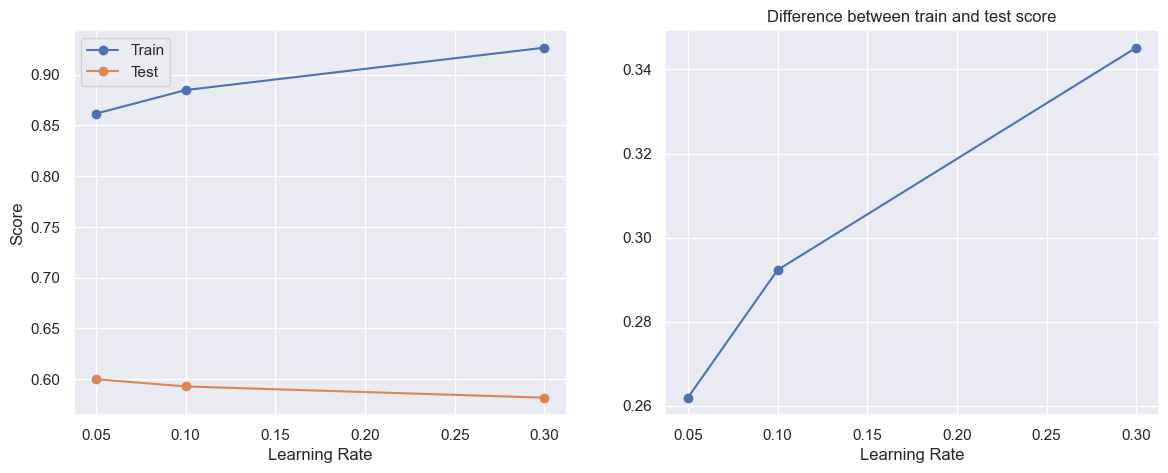

In [66]:
cv_r=pd.DataFrame(gridXG.cv_results_)

fig = plt.figure(figsize= (14,5))
plt.subplot(1,2,1)

plt.plot(cv_r['param_learning_rate'], cv_r['mean_train_score'], 'o-', label='Train')
plt.plot(cv_r['param_learning_rate'], cv_r['mean_test_score'], 'o-', label='Test')
plt.legend()
plt.ylabel('Score')
plt.xlabel('Learning Rate')
plt.subplot(1,2,2)
plt.plot(cv_r['param_learning_rate'], cv_r['mean_train_score']-cv_r['mean_test_score'], 'o-')
plt.title('Difference between train and test score')
plt.xlabel('Learning Rate')
plt.show();

Learning rate of 0.05 gives better test score and minimal difference between train and test score.

In [67]:
%%time
params = {'learning_rate':[0.05],
          'max_depth':[15], 
          'n_estimators':[150],
         'reg_lambda':[4,6,8,10,12]}
gridXGl = GridSearchCV(xgb, param_grid=params, cv=3, return_train_score=True, n_jobs=3)
gridXGl.fit(X_data, Y_data)

/Users/vijaypersonal/Library/Python/3.11/lib/python/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/vijaypersonal/Library/Python/3.11/lib/python/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/vijaypersonal/Library/Python/3.11/lib/python/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/vijaypersonal/Library/Python/3.11/lib/python/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instea

CPU times: user 14.9 s, sys: 1.58 s, total: 16.5 s
Wall time: 18.4 s


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.1, ma...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=15, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=150,
                                    n_jobs=None, nthread=3,
                                    num_parallel_tree=None, ...),
             n_jobs=3,
             param_grid={'learning_rate': [0.05], 'max_depth': [15],
                         'n_estimators': [150],
                         'reg_lambda': [4, 6, 8, 10, 12]},
             return_train_score=True)

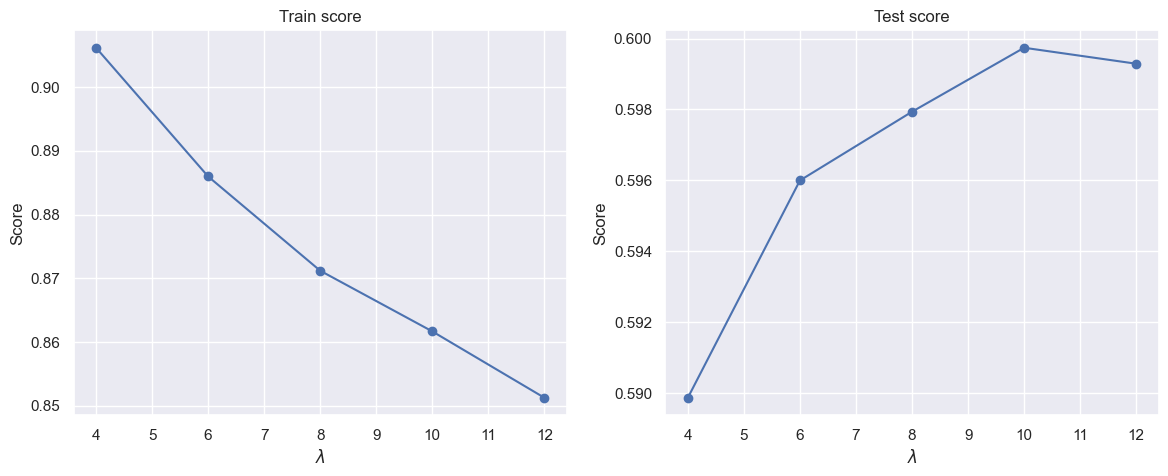

In [68]:
cv_rl=pd.DataFrame(gridXGl.cv_results_)

fig = plt.figure(figsize= (14,5))
plt.subplot(1,2,1)
plt.plot(cv_rl['param_reg_lambda'], cv_rl['mean_train_score'], 'o-', label='Train')
#plt.plot(cv_rl['param_reg_lambda'], cv_rl['mean_test_score'], 'o-', label='Test')
plt.title('Train score')
plt.xlabel(r'$\lambda$')
plt.ylabel('Score')
plt.subplot(1,2,2)
plt.plot(cv_rl['param_reg_lambda'], cv_rl['mean_test_score'], 'o-')
plt.xlabel(r'$\lambda$')
plt.title('Test score')
plt.ylabel('Score')
plt.show();

In [70]:
%%time
params = {'learning_rate':[0.05],
          'max_depth':[8,10,15,20,25], 
          'n_estimators':[150],
         'reg_lambda':[10]}
gridXGm = GridSearchCV(xgb, param_grid=params, cv=3, return_train_score=True, n_jobs=3)
gridXGm.fit(X_data, Y_data);

/Users/vijaypersonal/Library/Python/3.11/lib/python/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/vijaypersonal/Library/Python/3.11/lib/python/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/vijaypersonal/Library/Python/3.11/lib/python/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/vijaypersonal/Library/Python/3.11/lib/python/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instea

CPU times: user 12.5 s, sys: 1.44 s, total: 13.9 s
Wall time: 20.5 s


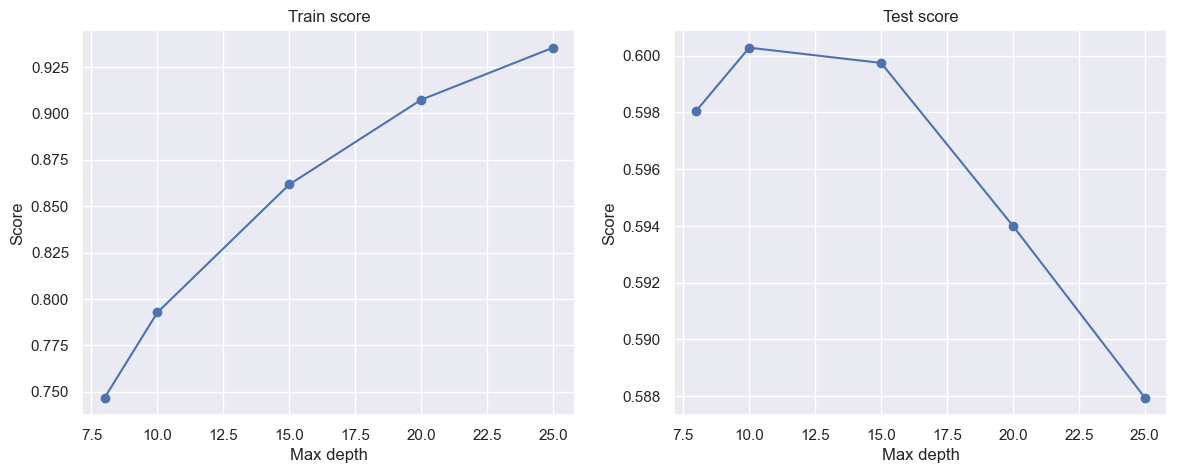

In [71]:
cv_rm=pd.DataFrame(gridXGm.cv_results_)
fig = plt.figure(figsize= (14,5))
plt.subplot(1,2,1)

plt.plot(cv_rm['param_max_depth'], cv_rm['mean_train_score'], 'o-', label='Train')
plt.title('Train score')
plt.xlabel('Max depth')
plt.ylabel('Score')

plt.subplot(1,2,2)
plt.plot(cv_rm['param_max_depth'], cv_rm['mean_test_score'], 'o-')
plt.title('Test score')
plt.xlabel('Max depth')
plt.ylabel('Score')
plt.show();

In [75]:
%%time
params = {'learning_rate':[0.05],
          'max_depth':[15], 
          'n_estimators':[100,150,200,300],
         'reg_lambda':[10]}
gridXGe = GridSearchCV(xgb, param_grid=params, cv=3, return_train_score=True, n_jobs=3)
gridXGe.fit(X_data, Y_data);

/Users/vijaypersonal/Library/Python/3.11/lib/python/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/vijaypersonal/Library/Python/3.11/lib/python/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/vijaypersonal/Library/Python/3.11/lib/python/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/vijaypersonal/Library/Python/3.11/lib/python/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instea

CPU times: user 12.8 s, sys: 1.08 s, total: 13.9 s
Wall time: 15.8 s


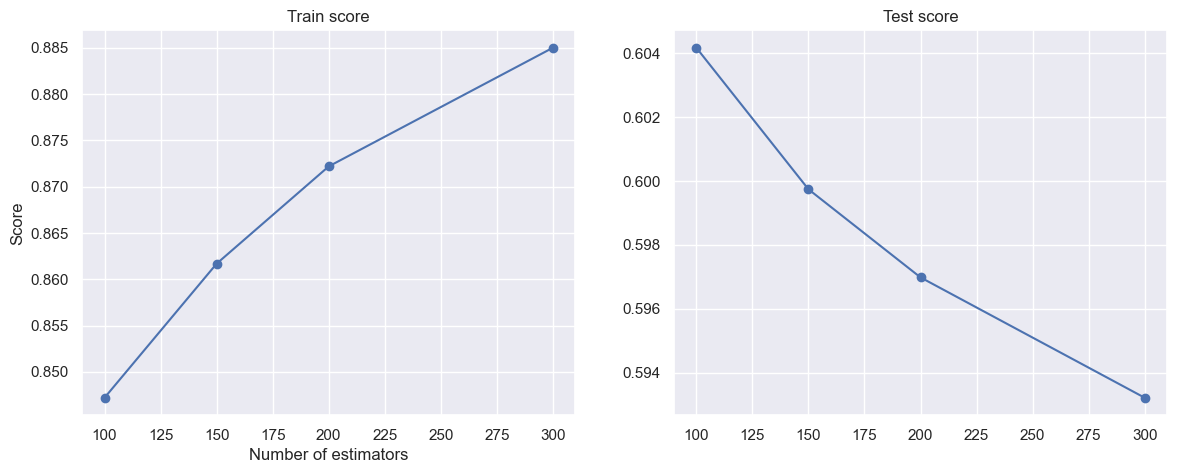

In [77]:
cv_re=pd.DataFrame(gridXGe.cv_results_)

fig = plt.figure(figsize= (14,5))
plt.subplot(1,2,1)
plt.title('Train score')
plt.plot(cv_re['param_n_estimators'], cv_re['mean_train_score'], 'o-')
plt.ylabel('Score')
plt.xlabel('Number of estimators')
plt.subplot(1,2,2)
plt.title('Test score')
plt.plot(cv_re['param_n_estimators'], cv_re['mean_test_score'], 'o-')
plt.show();

After tuning hyper parameters of XGBoost model we found a set of hyper parameters which gives the best test score. Because GridSearchCV takes a lot time to run over large parameter space, we ran GridSearch on sample dataset 15% of the size of original dataset. Now we can run XGBoost on the entire dataset with optimal hyperparameter to find score of the model. 

In [78]:
%%time

Xf=df_makemodel_dummy.drop(['id','price','log_price','odometer'], axis=1)
Yf=df_makemodel_dummy['log_price']

X_trainf, X_testf, y_trainf, y_testf = train_test_split(Xf,Yf, test_size=0.2)

xgbf=XGBRegressor(learning_rate=0.05, max_depth=15, n_estimators=100, 
                nthread=3,reg_lambda=10,random_state=44)
results_xgbf=xgbf.fit(X_trainf, y_trainf)

print('Train score:',xgbf.score(X_trainf, y_trainf))
print('Test score:',xgbf.score(X_testf, y_testf))

Train score: 0.8031986252390294
Test score: 0.7263790938312145
CPU times: user 46.4 s, sys: 2.44 s, total: 48.9 s
Wall time: 14 s


In [131]:
y_pred_test = xgbf.predict(X_testf)
print("Mean absolute error of the prediction is: {:.0f}$".format( 
    np.mean(np.abs(np.exp(y_pred_test)-np.exp(y_testf)))))
print("Mean relative error of the prediction is: {0:.3g}%".format( 
    np.mean(np.abs(np.exp(y_pred_test)-np.exp(y_testf))/np.exp(y_testf))))

Mean absolute error of the prediction is: 3159$
Mean relative error of the prediction is: 1.03%


## Error Analysis

In [81]:
y_pred_train = xgbf.predict(X_trainf)
y_pred_test = xgbf.predict(X_testf)

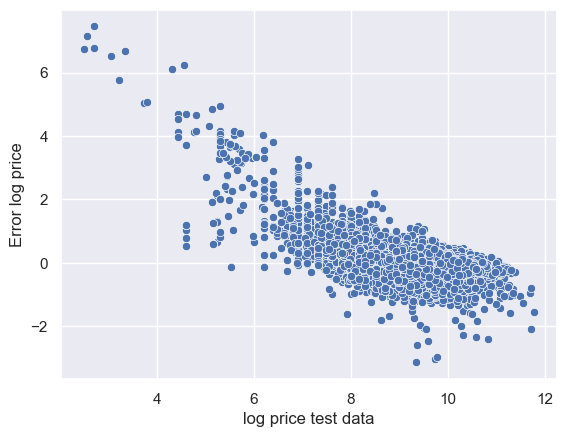

In [82]:
sns.scatterplot(x=y_testf, y =y_pred_test-y_testf)
plt.xlabel('log price test data')
plt.ylabel('Error log price');

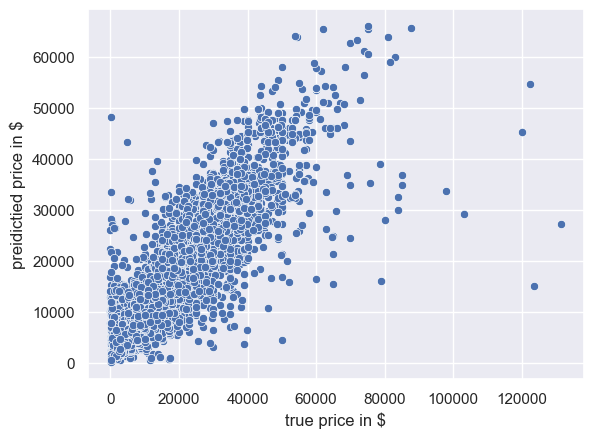

In [83]:
sns.scatterplot(x=np.exp(y_testf), y =np.exp(y_pred_test))
plt.xlabel('true price in $')
plt.ylabel('preidictied price in $');

From the plot above we can see that model does not predict well prices over $80k, because dataset does not contains enough expensive cars for good model training.

## Summary

In summary based on information of used vehicles from craigslist I build predictive model which help help to estimate prices of used vehicles. XGBoost model gives the best performance with the best accuracy of 0.73 and mean absolute error of ~$3000 in price prediction. Although this number seems high, on average the difference between the prediction and the list price is only 1% relative to the list price .

This model could be useful for people who wants to buy used car or sell their cars, as well for dealers and other car businesses. For further improvement of the model and increase it accuracy and versatility dataset with more features is need. Such thing if car has some customization, tuning or upgrades would be very interesting for car enthusiasts.
